# **Reading in the data**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import itertools
import community
import re
import csv
from fa2 import ForceAtlas2
from backbone import *

# Loading the data from 3 different pickle files
folder = "../Movie Dataframe with Ratings/"
df1 = pd.read_pickle(folder+"networkData1.pkl")
df2 = pd.read_pickle(folder+"networkData2.pkl")
df3 = pd.read_pickle(folder+"networkData3.pkl")

# Merge the 3 dataframes to one and reset index
frames = [df1, df2, df3]
moviesDf = pd.concat(frames, axis=0, ignore_index=True)

In [2]:
# Extracting actors and movies with duplicate names
actor_column = list(moviesDf["Actors"].to_numpy())
actors = [actor for cast in actor_column for actor in cast]
duplicates = set(actors) & set(moviesDf["MovieTitle"].to_numpy())
duplicates

# Removing movies where an Actor is called the same
moviesDf.drop(moviesDf[moviesDf['MovieTitle'].isin(duplicates)].index, inplace = True)

In [3]:
# Extracting relevant columns
genres = (moviesDf['Genres'].to_numpy())
rating_column = moviesDf['Rating'].to_numpy()
genre_column = [re.findall(r"'name': '(.*?)'}", s) for s in genres]
title_column = moviesDf["MovieTitle"].to_numpy()
actor_column = list(moviesDf["Actors"].to_numpy())

actorsDistinct = [*set([actor for cast in actor_column for actor in cast])]

In [4]:
# Adding no genre to movies with no genre attribute
for i,genre in enumerate(genre_column):
    try:
        genre[0]
    except:
        genre_column[i] = ['No genre']

# Constructing the graphs

**Generating the bipartite network of Actors and Movies**

In [5]:
# Constructing NetworkX graph
G = nx.Graph()

# Add all movies as nodes with genre attribute
for i, title in enumerate((title_column)):
    G.add_node(title, bipartite=0, Genre = genre_column[i][0])

# Add all actors as nodes
G.add_nodes_from(actorsDistinct, bipartite=1)

# Adding links between each movie and its actors
for i, movie in enumerate(title_column):
    G.add_edges_from(list(zip(itertools.repeat(movie), actor_column[i])))

In [6]:
# Check if the resulting network is bipartite
bipartite.is_bipartite(G)

True

**Basic stats for the bipartite network**

In [7]:
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

Nodes: 137704
Edges: 255020



**Extracting the projected Actor Network and the Movie Network from the biparite graph**

In [8]:
# Extracting movie and actor nodes from each part of the bipartite graph
actorNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
movieNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}

# Create the weighted bipartite graphs
actorNetwork = bipartite.weighted_projected_graph(G, actorNodes, ratio = False)
movieNetwork = bipartite.weighted_projected_graph(G, movieNodes, ratio = False)

In [9]:
# Printing nodes and edges stats
print(f'Actor network stats')
print(f'Nodes: {actorNetwork.number_of_nodes()}')
print(f'Edges: {actorNetwork.number_of_edges()}\n')

print(f'Movie network stats')
print(f'Nodes: {movieNetwork.number_of_nodes()}')
print(f'Edges: {movieNetwork.number_of_edges()}\n')

Actor network stats
Nodes: 131746
Edges: 8086719

Movie network stats
Nodes: 5958
Edges: 468645



# Extracting backbone of networks

In [10]:
# Applying the disparity filter to both networks
actorAlphaNetwork = disparity_filter(actorNetwork)
movieAlphaNetwork = disparity_filter(movieNetwork)

In [11]:
# Defining the alpha value to determine the coarseness of the filter
alphaActor = 0.12
actorNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in actorAlphaNetwork.edges(data=True) if d['alpha'] < alphaActor])
alphaMovie = 0.12
movieNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in movieAlphaNetwork.edges(data=True) if d['alpha'] < alphaMovie])

In [12]:
# Printing nodes and edges stats
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 5820
Edges: 23472

Movie network backbone stats
Nodes: 3841
Edges: 12874



# Plotting Actors network 

In [13]:
# Removing nodes with very small degree
remove = [node for node,degree in dict(actorNetworkBackbone.degree()).items() if degree < 4]
actorNetworkBackbone.remove_nodes_from(remove)

In [14]:
# Extracting largest connected component
nodes = max(nx.connected_components(actorNetworkBackbone), key=len)
actorNetworkBackbone = actorNetworkBackbone.subgraph(nodes).copy()

In [15]:
# Defining parameters for forceatlas algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

In [16]:
# Defining positioning of nodes for the plot
positions = forceatlas2.forceatlas2_networkx_layout(actorNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.13it/s]

BarnesHut Approximation  took  8.42  seconds
Repulsion forces  took  3.68  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


In [17]:
# Defining node size based on node degree
d = dict(actorNetworkBackbone.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

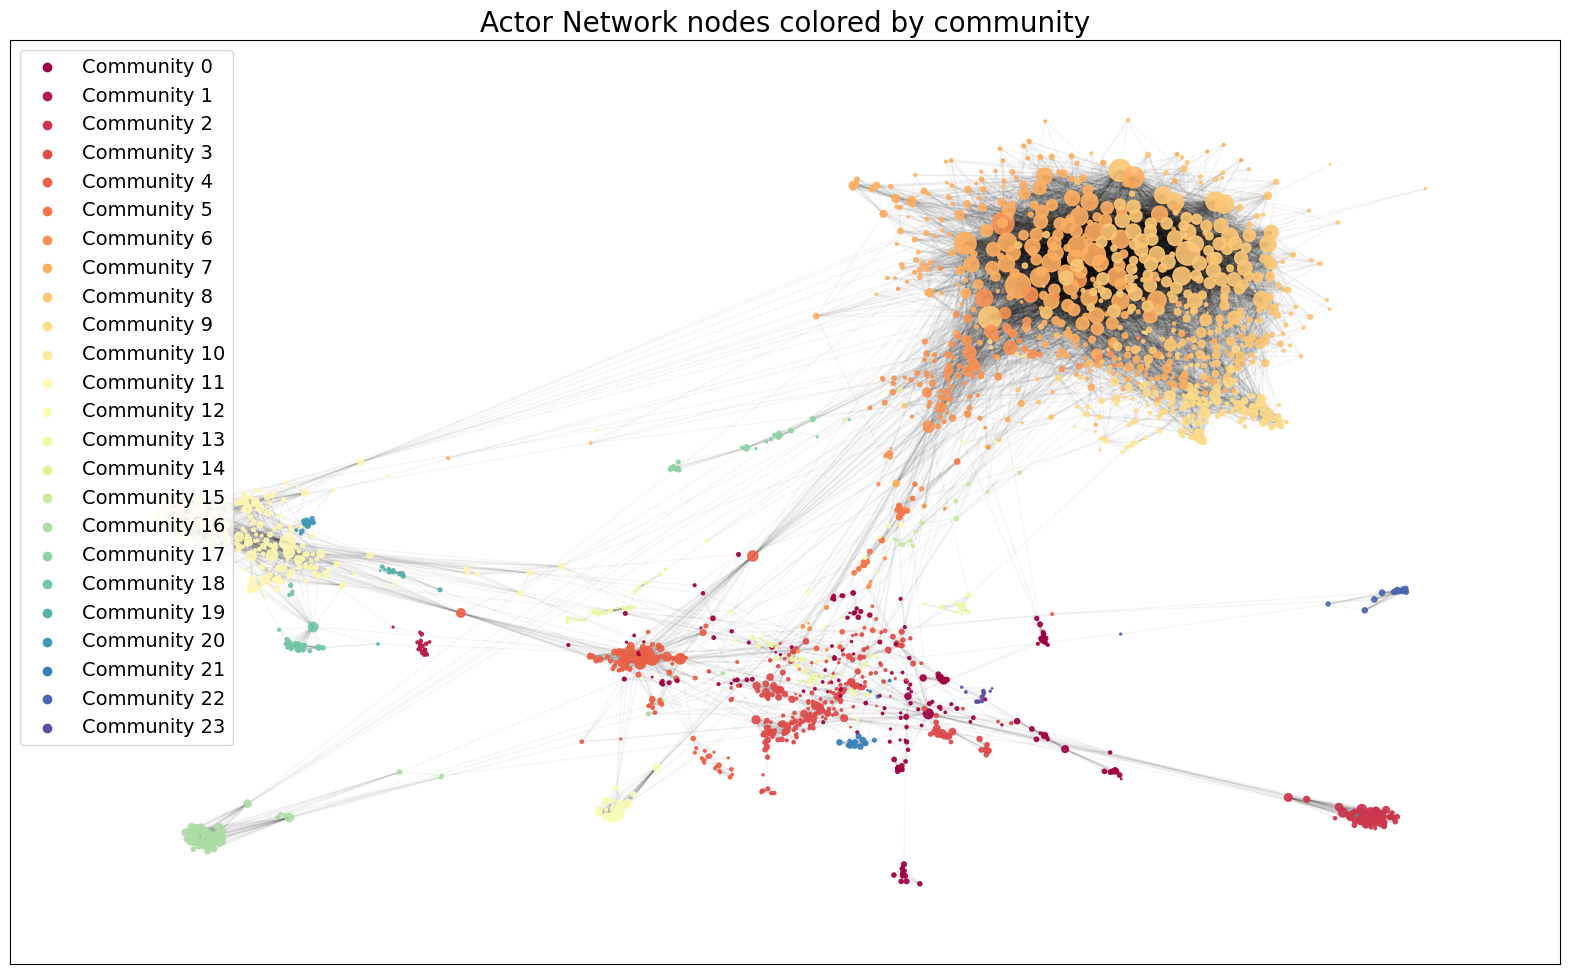

In [18]:
# Best partition found with louvain algorithm
actorPartition = community.best_partition(actorNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(actorPartition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in actorPartition.values()]

# Plotting
fig = plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(actorNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(actorNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(actorPartition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Actor Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('actorNetwork.png')
plt.show()



In [20]:
# rearanging found partition
partsActor = []
for i in range(0, len(set(actorPartition.values()))):
    partsActor.append([])
    
for actor, com in actorPartition.items():
    partsActor[com].append(actor)

#sorting based on biggest communities
partsActorSorted = partsActor
partsActorSorted.sort(key=len, reverse = True)

# Plotting network Movies


In [21]:
# Removing nodes with very small degree
remove = [node for node,degree in dict(movieNetworkBackbone.degree()).items() if degree < 6]
movieNetworkBackbone.remove_nodes_from(remove)

In [22]:
# Extracting largest connected component
nodes = max(nx.connected_components(movieNetworkBackbone), key=len)
movieNetworkBackbone = movieNetworkBackbone.subgraph(nodes).copy()

In [23]:
# Defining positioning of nodes for the plot
positions = forceatlas2.forceatlas2_networkx_layout(movieNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.90it/s]

BarnesHut Approximation  took  4.27  seconds
Repulsion forces  took  1.90  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


In [24]:
# Defining node size based on node degree
d = dict(movieNetworkBackbone.degree).values()
scale = 4
node_size = [degree*scale for degree in d]

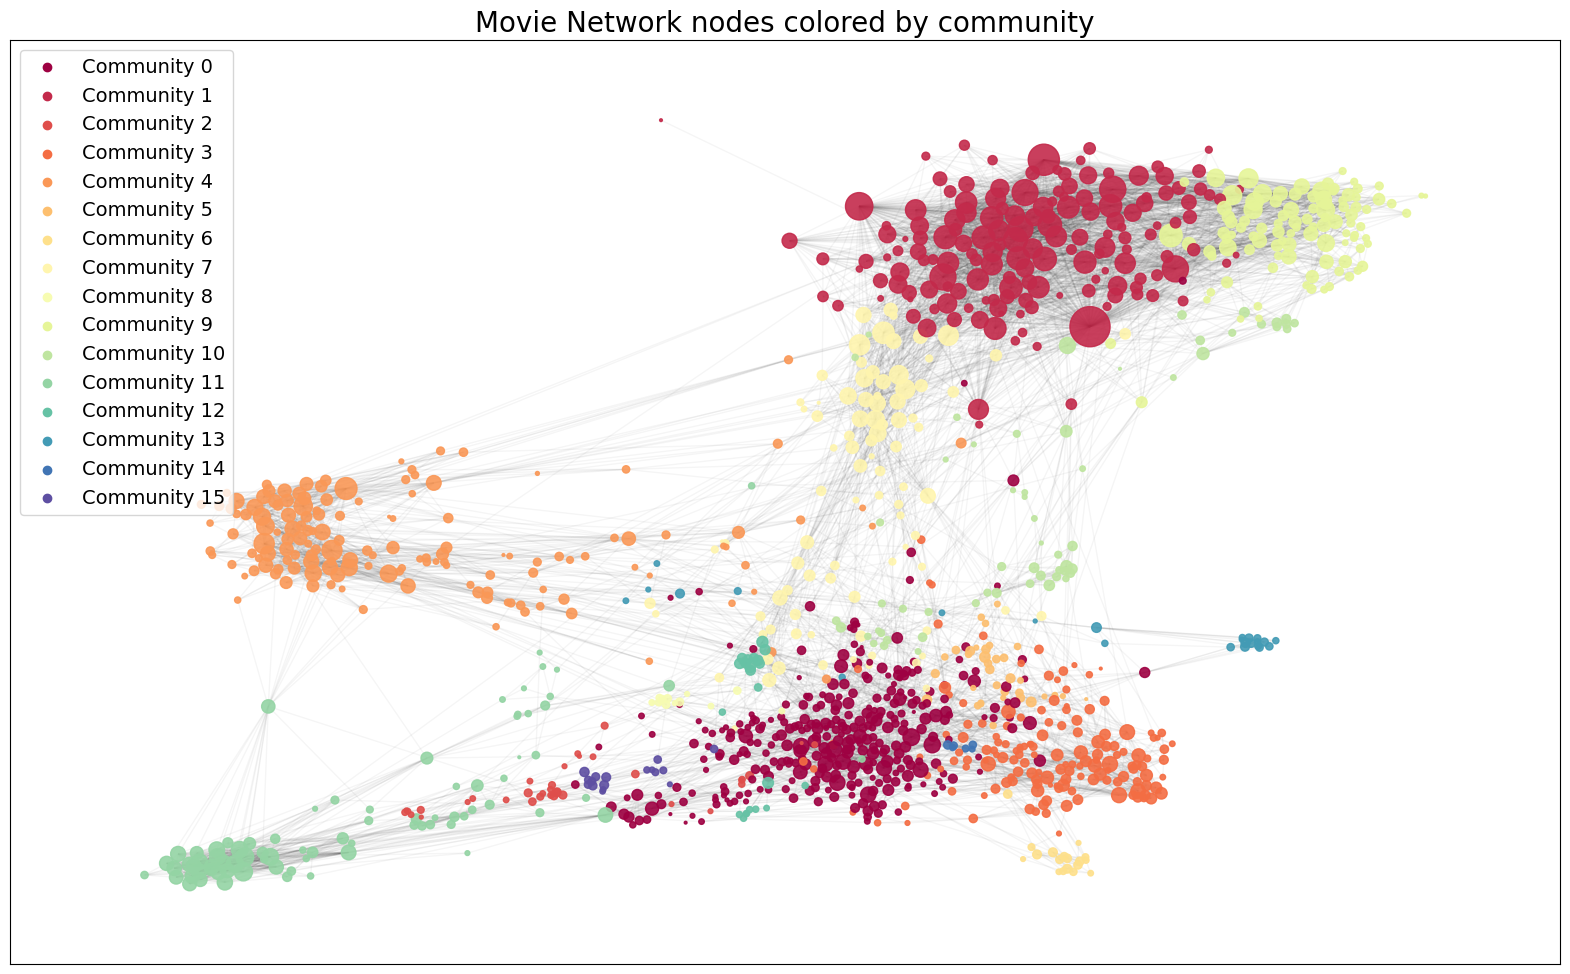

In [25]:
# Best partition found with louvain algorithm
moviePartition = community.best_partition(movieNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(moviePartition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in moviePartition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(movieNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(movieNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(moviePartition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Movie Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('movieNetwork.png')
plt.show()

In [26]:
# rearanging found partition
partsMovie = []
for i in range(0, len(set(moviePartition.values()))):
    partsMovie.append([])
    
for movie, com in moviePartition.items():
    partsMovie[com].append(movie)
    
#sorting based on biggest communities
partsMovieSorted = partsMovie
partsMovieSorted.sort(key=len, reverse = True)

# Analysing found communities

In [27]:
# Printing nodes and edges stats
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 2040
Edges: 18374

Movie network backbone stats
Nodes: 1277
Edges: 8480



In [37]:
# Finding top connected movies and actors
#movieBackboneDegrees = sorted(movieNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)
#actorBackboneDegrees = sorted(actorNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)
movieBackboneDegrees = sorted(movieNetwork.degree(), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetwork.degree(), key=lambda x: x[1], reverse=True)


print(f'Top 10 connected movies:')
for movie, degree in movieBackboneDegrees[:10]:
    print(f'{movie:<40}{degree}')
    
print(f'\nTop 10 connected actors:')
for actor, degree in actorBackboneDegrees[:10]:
    print(f'{actor:<40}{degree}')

Top 10 connected movies:
The Player                              928
Mighty Joe Young                        833
Independence Day                        811
Around the World in Eighty Days         808
Hamlet                                  800
Titanic                                 776
Ocean's Eleven                          759
Nixon                                   752
JFK                                     711
The Fan                                 706

Top 10 connected actors:
Greg Bronson                            5787
Sam Harris                              4682
Arthur Tovey                            4528
Bess Flowers                            4516
Bert Stevens                            4047
Paul McMichael                          3990
Harold Miller                           3878
Jeffrey Sayre                           3849
Michael Jeffers                         3522
Norman Stevans                          3502


In [38]:
# Defining movie genres
com = partsMovie[6]
genreAtt = G.nodes(data='Genre')
for movie in com:
    print(f'{movie:<40}{genreAtt[movie]}')

The Rugrats Movie                       Animation
The Powerpuff Girls Movie               Animation
The Hunchback of Notre Dame             Drama
Jimmy Neutron: Boy Genius               Action
Rugrats in Paris: The Movie             Adventure
Recess: School's Out                    Science Fiction
Theodore Rex                            Fantasy
The Transformers: The Movie             Animation
Mulan                                   Animation
The Lion King                           Family
Beauty and the Beast                    Romance
The Rescuers Down Under                 Adventure
Anastasia                               Animation
となりのトトロ                                 Fantasy
Spirit: Stallion of the Cimarron        Western
Toy Story                               Animation
Toy Story 2                             Animation
Hercules                                Animation
An American Tail: Fievel Goes West      Adventure
千と千尋の神隠し                                Fantasy
A Bug's Life  

# Clustering by genre

In [39]:
movieNodes = list(movieNetworkBackbone.nodes())
genreNetwork = G.subgraph(movieNodes).copy()
movieGenre = {movie[0]: movie[1]['Genre'] for movie in genreNetwork.nodes(data=True)}
nx.set_node_attributes(movieNetworkBackbone, movieGenre, name = 'Genre')

In [40]:
set([genre for actor,genre in genreAtt])

genreCommunities = []
for genre in set([genre for actor,genre in genreAtt]):
    genreCommunities.append([node[0] for node in genreNetwork.nodes(data=True) if node[1]['Genre'] == genre])

# Modularity scores

In [41]:
# Printing modularity scores for movie network
print(f'Modularity with genre as community in movie network: {nx.algorithms.community.modularity(movieNetworkBackbone, genreCommunities)}')
print(f'Modularity with Louvain algorithm  in movie network: {nx.algorithms.community.modularity(movieNetworkBackbone, partsMovie)}')

Modularity with genre as community in movie network: 0.08661085345793362
Modularity with Louvain algorithm  in movie network: 0.6598414352348618


In [42]:
# Printing modularity scores for actor network
print(f'Modularity with Louvain algorithm in actor network: {nx.algorithms.community.modularity(actorNetworkBackbone, partsActor)}')

Modularity with Louvain algorithm in actor network: 0.5636890360612994


# Files for analysis

In [43]:
# Writing the movie communitites to file with genre attribute
textfile = open("MovieCommunities.txt", "w")
for element in partsMovie:   
    for word in element:
        try:
            textfile.write(f'{word:<40}{genreAtt[word]}\n')
        except:
            print('Can\'t write special characters')
    textfile.write("\n\n\n")
textfile.close()

Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
Can't write special characters
